In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')

In [3]:
train = train[train.Quality > 1]

In [4]:
def sample_pixel(fid, pixel_a, pixel_b, month_range, folder='image_arrays_train'):
    fn = f'{folder}/{fid}.npy'
    arr = np.load(fn)
    bands = ['S2_B1', 'S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 
             'S2_B6', 'S2_B7', 'S2_B8', 'S2_B8A', 'S2_B9', 
             'S2_B10', 'S2_B11', 'S2_B12', 'S2_QA10', 'S2_QA20', 
             'S2_QA60', 'CLIM_aet', 'CLIM_def', 'CLIM_pdsi', 'CLIM_pet', 
             'CLIM_pr', 'CLIM_ro', 'CLIM_soil', 'CLIM_srad', 'CLIM_swe', 
             'CLIM_tmmn', 'CLIM_tmmx', 'CLIM_vap', 'CLIM_vpd', 'CLIM_vs']
    # exclude bands 13, 14, and 24
    band_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16 , 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29]
    bands_of_interest = [bands[x] for x in band_idxs]
    values = {}
    for month in range(month_range[0], month_range[1]):
        bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
        idxs = np.where(np.isin(band_names, bns)) # Index of these bands
        # get the whole image in the form of an array
        vs = np.empty(idxs[0].size)
        i=0
        for idx in idxs[0]:          
            vs[i] = arr[idx, pixel_a, pixel_b]
            i+=1
        #vs = arr[idxs, 20, 20]
        for bn, v in zip(bns, vs):
            values[bn] = v
    return values

In [7]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

In [8]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([sample_pixel(fid, 20, 20, range(0,12)) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values

In [9]:
def split_train(data):
    # Split the data  
    data_train = data[0:int(np.floor(data.shape[0]*0.7))]
    data_val = data[int(np.floor(data.shape[0]*0.7)):int(np.floor(data.shape[0]*0.9))]
    data_test = data[int(np.floor(data.shape[0]*0.9)):]
    return (data_train, data_val, data_test)

def split_xy(train_sampled):
    # Split the data
    X, y  = train_sampled[train_sampled.columns[:-2]], train_sampled['Yield']   
    return (X, y)

def split(train_sampled):
    data_train, data_val, data_test = split_train(train_sampled)
    X_train, y_train = split_xy(data_train)
    X_val, y_val = split_xy(data_val)
    X_test, y_test = split_xy(data_test)
    return (X_train, y_train, X_val, y_val, X_test, y_test)

In [29]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import time

X_train, y_train, X_val, y_val, X_test, y_test = split(train_sampled)
scores = []
for i in range(1,12):
    print(i)
    intermediate_scores = []
    #model = RandomForestRegressor(n_estimators=50, max_depth=i)
    model = AdaBoostRegressor(n_estimators=100)
    for i in range(5):
        model.fit(X_train,y_train)
        intermediate_scores.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    scores.append(np.mean(intermediate_scores))




1
2
3
4
5
6
7
8
9
10
11


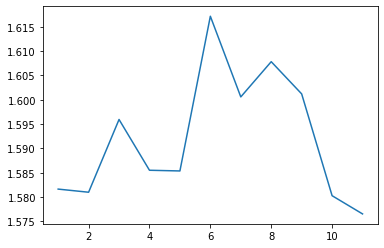

In [30]:
plt.plot(range(1,12), scores)

In [28]:
print(min(scores))

1.469916427917432
